# MERFISH DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot


fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/merfish.h5ad")

In [4]:
gene

AnnData object with n_obs × n_vars = 243799 × 254
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'

In [5]:
gene = gene[:,gene.var.sort_index().index]

In [6]:
print(gene.shape)

(243799, 254)


In [7]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.index.values
assignments   = gene.obs.subclass.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

01-Nov-20 16:32:56 - 1 of 26 assignments: Astrocytes
01-Nov-20 16:32:57 - 2 of 26 assignments: Endothelial
01-Nov-20 16:32:57 - 3 of 26 assignments: Ependymal
01-Nov-20 16:32:57 - 4 of 26 assignments: L2/3_IT
01-Nov-20 16:32:58 - 5 of 26 assignments: L4/5_IT
01-Nov-20 16:32:58 - 6 of 26 assignments: L56_NP
01-Nov-20 16:32:58 - 7 of 26 assignments: L5_IT
01-Nov-20 16:32:58 - 8 of 26 assignments: L5_PT
01-Nov-20 16:32:59 - 9 of 26 assignments: L6_CT
01-Nov-20 16:32:59 - 10 of 26 assignments: L6_IT
01-Nov-20 16:32:59 - 11 of 26 assignments: L6_IT_Car3
01-Nov-20 16:33:00 - 12 of 26 assignments: L6b
01-Nov-20 16:33:00 - 13 of 26 assignments: Lamp5
01-Nov-20 16:33:00 - 14 of 26 assignments: Macrophages
01-Nov-20 16:33:00 - 15 of 26 assignments: Microglia
01-Nov-20 16:33:01 - 16 of 26 assignments: OPC
01-Nov-20 16:33:01 - 17 of 26 assignments: Oligodendrocytes
01-Nov-20 16:33:01 - 18 of 26 assignments: Pericytes
01-Nov-20 16:33:01 - 19 of 26 assignments: Pvalb
01-Nov-20 16:33:02 - 20 of 26 as

CPU times: user 4.56 s, sys: 3.64 s, total: 8.21 s
Wall time: 8.19 s


# Look at thngs

In [8]:
alpha = 0.01
markers_gene = markers_gene.query(f"p_corr < {alpha}")
markers_gene.sort_values("es").iloc[-10:-1]

,index,name,p_raw,p_corr,es
5217,Sncg,Npas1,0,2.22507e-308,9.79975
5724,Sst_Chodl,Nos1,1.46833e-186,4.40499e-185,9.80645
2683,L6_IT_Car3,Nr4a2,0,2.22507e-308,9.86363
3623,Microglia,Ctss,0,2.22507e-308,9.88532
340,Endothelial,Flt1,0,2.22507e-308,10.1156
5945,VLMC,Igf2,0,2.22507e-308,10.15
4277,Oligodendrocytes,Sox10,0,2.22507e-308,10.2404
306,Endothelial,Cldn5,0,2.22507e-308,10.2858
4567,Pericytes,Vtn,0,2.22507e-308,10.7161


In [9]:
specific_cluster = "Sst_Chodl"
specific_gene = "Nos1"

In [10]:
specific_gene

'Nos1'

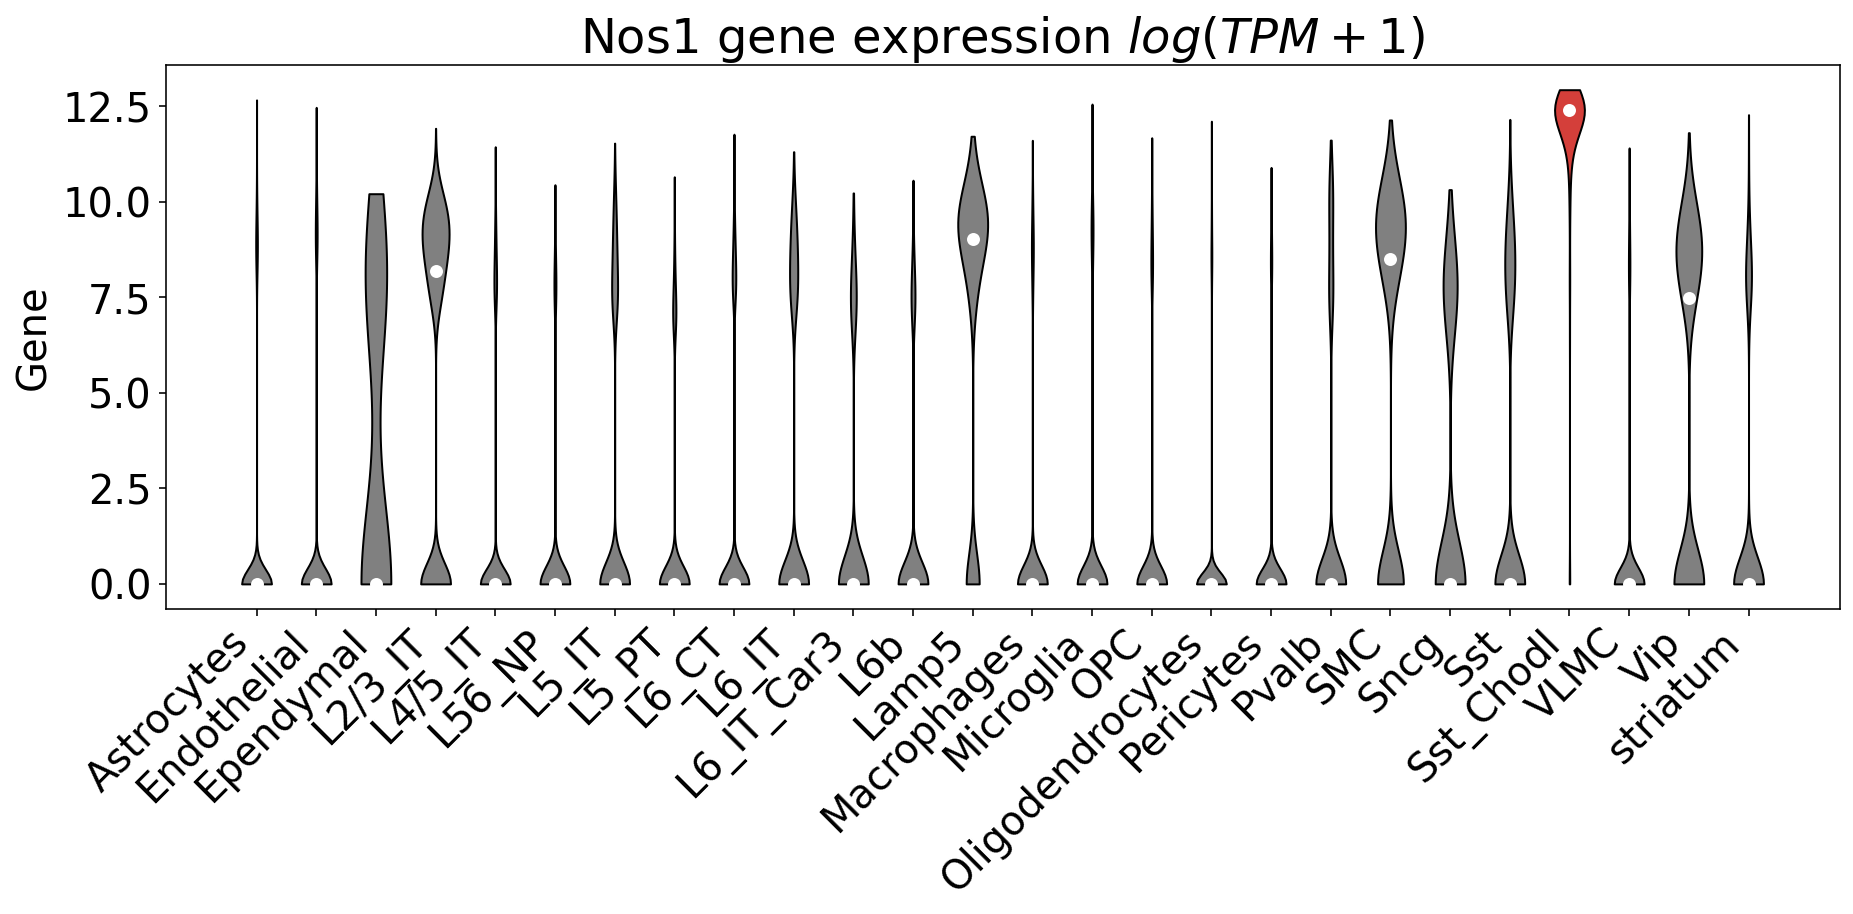

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass==c][:,gene.var.index.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax.set_ylabel("Gene")


medians = [np.median(i) for i in x]
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))
#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [12]:
identified_genes = markers_gene["name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [13]:
print("{} genes identified.".format(identified_genes.nunique()))

119 genes identified.


In [14]:
%%time
mtx = gene.layers["log1p"].todense()
markers_gene["mean_log1p"] = markers_gene.name.apply(lambda x: mtx[:,gene.var.index.values==x].mean())

CPU times: user 1.82 s, sys: 416 ms, total: 2.23 s
Wall time: 2.23 s


In [15]:
%%time
mtx = gene.layers["norm"]
markers_gene["mean_norm"] = markers_gene.name.apply(lambda x: mtx[:,gene.var.index.values==x].mean())

CPU times: user 402 ms, sys: 153 ms, total: 555 ms
Wall time: 553 ms


In [41]:
markers_gene.to_csv("../../tables/unordered/merfish_DE.csv")

In [16]:
markers_gene

,index,name,p_raw,p_corr,es,mean_log1p,mean_norm
12,Astrocytes,Aqp4,0,2.22507e-308,6.78551,4.221101,10383.038046
26,Astrocytes,Calb1,3.40387e-248,4.42503e-247,-0.518873,6.653187,1952.531619
69,Astrocytes,Cxcl14,0,2.22507e-308,5.50498,5.064552,10335.149866
70,Astrocytes,Daam2,0,2.22507e-308,6.32225,4.587045,12779.296338
93,Astrocytes,Gad2,0,2.22507e-308,-0.298073,8.113238,4278.066673
...,...,...,...,...,...,...,...
6574,striatum,Tac2,7.58643e-26,1.66901e-24,0.306678,6.684355,1421.670474
6578,striatum,Tenm3,0,2.22507e-308,3.44809,5.620546,10128.173393
6581,striatum,Thsd7a,0,2.22507e-308,6.74809,3.122554,5100.767770
6597,striatum,Vip,3.20207e-119,7.04455e-118,-0.416486,7.769147,2975.553447
